<a href="https://colab.research.google.com/github/AuraFrizzati/GoogleCloud-Terraform-EDX-course/blob/main/03_Writing_Infrastructure_Code_for_Google_Cloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[03] Writing Infrastructure Code for Google Cloud**

**Objectives**

In this module, you will explore more about resources, variables, and output resources.

We will begin by exploring how to create infrastructure components using **resources** and then explore how Terraform handles **dependencies** within resources.

While we have been covering resource creation by using hard-code resource arguments, we will explore how you can **parameterize** a given **configuration** using **variables**. We will explore the syntax to declare, define and use them within your configuration.

We will then discuss how you can **export resource attributes outside the resource declaration** using **output values**.

We will then wrap up the module by discovering how you can **simplify code authoring** using **Terraform registry**, and **Cloud Foundation Toolkit**.

Upon completing this module you will be able to

- **Declare the resources** within Terraform.
- Explain **implicit** and **explicit resource dependencies**.
- Use **variables** and **output values** within the root configuration.
- Explain **Terraform Registry** and **Cloud Foundation Toolkit**.



This module focusses on the first phase of the Terraform workflow, the **Author phase**. During this phase you write your Terraform code in the HCL language.

## **3.1: Introduction to Resources**

**What are Resources?**

- Resources are **infrastructure elements**, such as: compute engine instances, VPC (Virtual Private Cloud), Cloud Storage bucket and Firewall rules. These elements can be **configured** using **Terraform code**.
- Terraform uses the **underlying APIs** of each Google Cloud service to deploy your resources

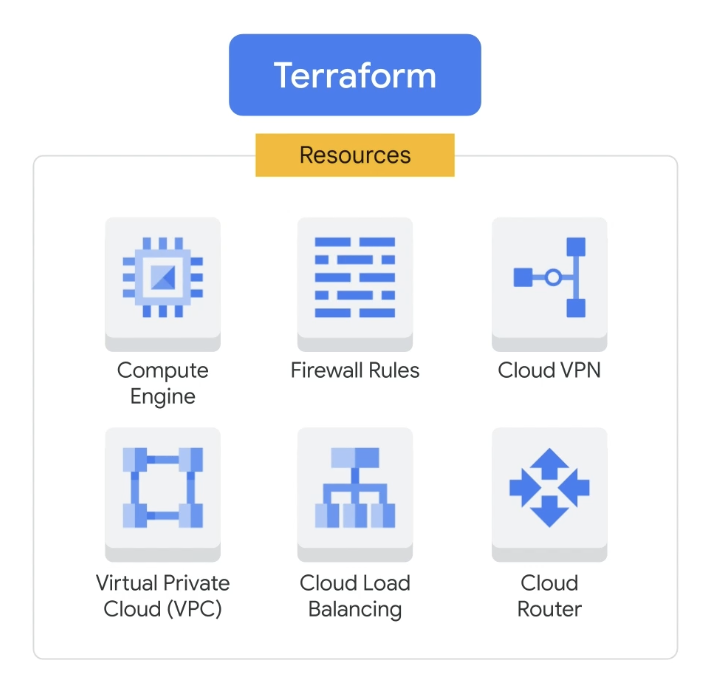

**Syntax to declare a resource**

- Resources are defined within a `.tf` file
- It is recommended that you place similar types of resources in a directory and define the resources in the `main.tf` file

```
-- network/
  -- main.tf
  -- outputs.tf
  -- variables.tf
```

```
resource "resource_type" "resource_name" {
  # Resource arguments
}
```

- The **resource block** is used to declare a **single infrastructure object**
- The `resource_type` identifies the **type of resource** being created and **depends on the provider being declared** within a Terraform module
- A **provider** is a **plugin that provides a collection of resource types**. Generally a provider is a **cloud infrastructure platform** (e.g. Google Cloud)
- **Resource arguments** are expressions to declare resources' **attributes**. Not all resource arguments must be defined, although some are instead mandatory for resource creation. Attributes can be used to define any **advanced feature** associated with a resource

**A configuration file can include multiple resources**

- You can include **multiple resources** of the same or different types in the **same Terraform configuration file**.

- These resources can even span across **multiple providers**


```
resource "google_compute_network" "vpc_network" {
  name                    = vpc-network" # Required argument
  project                 = "<Project_ID>"
  auto_create_subnetworks = false
  mtu                     = 1460
}

resource "google_compute_subnetwork" "subnetwork-ipv6" {
name                      = "ipv6-test-subnetwork" # Required argument
ip_cidr_range             = "10.0.0.0/22" # Required argument
network                   = google_compute_network.vpc_network.id # Required argument
region                    = "us-west2"

}
```

- A **resource** is identified by the `resource` keyword, followed by the **resource type**
- The resource arguments depend on the resource type.

- To **access a resource's attribute from another resource block**, use **`<resource_type>.<resource_name>.<attribute>`**
  - In the above example, the `vpc_network.id` is a computed resource attribute of a `google_compute_network` block. The `id` attribute is generated when the `vpc_network` resource is created.
  - This method can only be used when **resources** are **defined within the same root configuration**.

**Considerations for defining a resource block**

- The **resource name** of a **given resource type** must be **unique within the module**. A resource with the same name cannot exists within the same configuration:

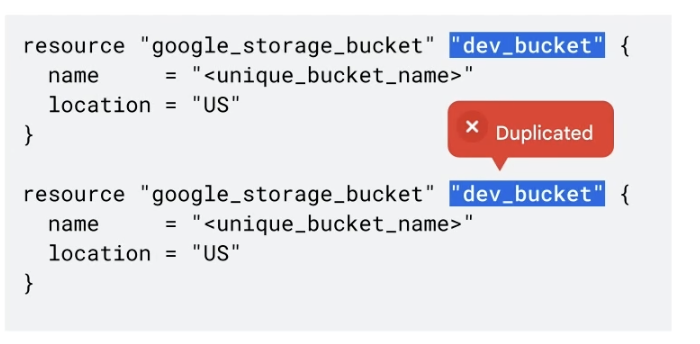

- The **resource type** is not user-defined and is a keyword **based on the provider**:

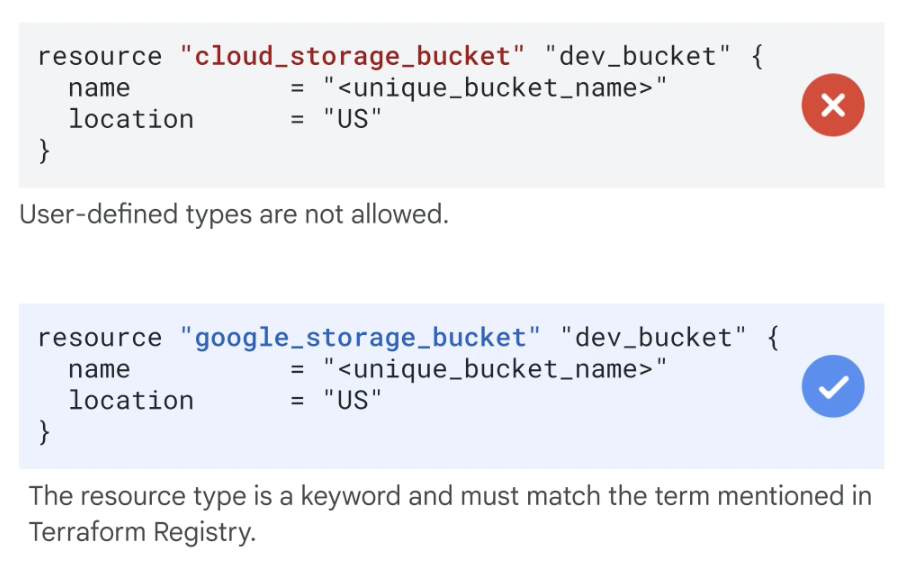

- All **configuration arguments** must be enclosed **within the resource block body** (i.e. within the curly brackets):


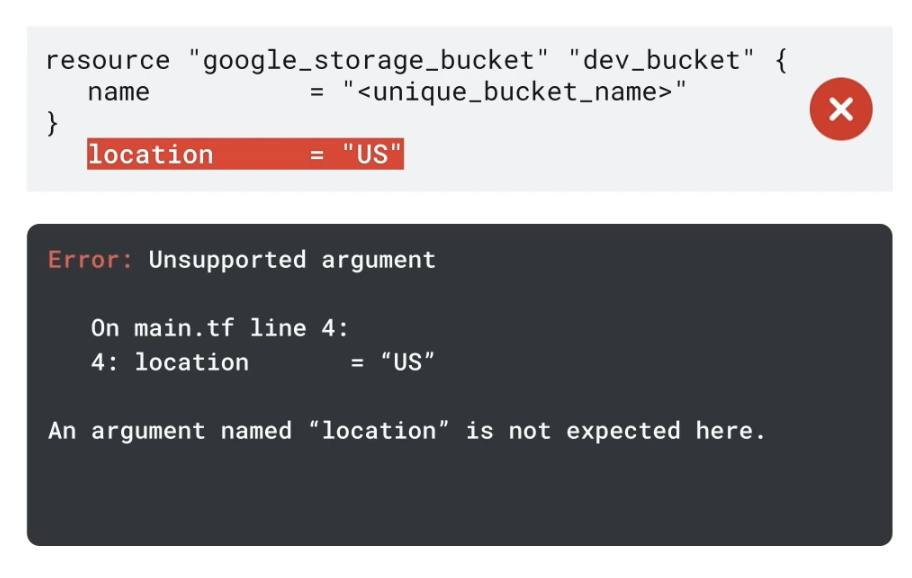

- All **required resource arguments** must be **defined**:


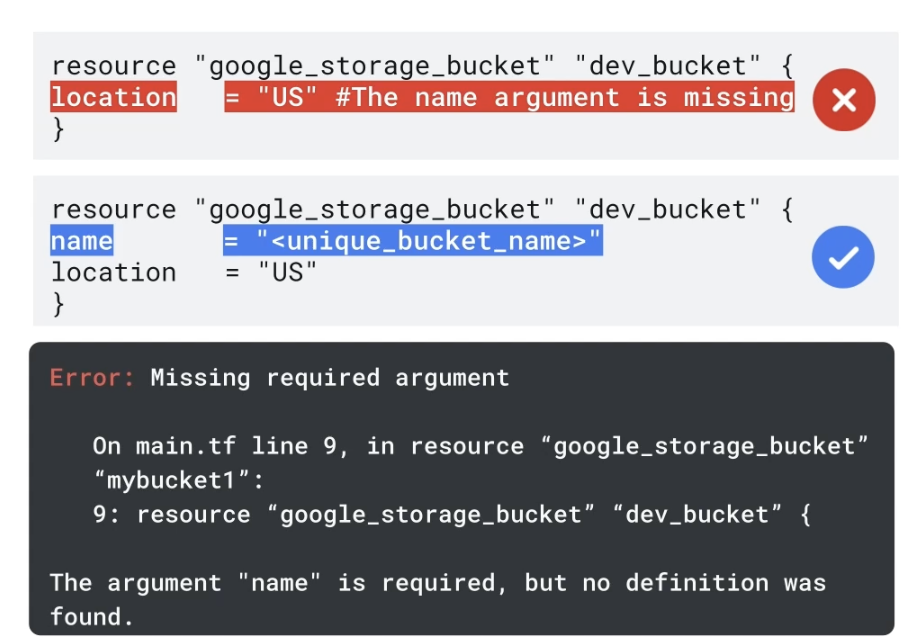

## **3.2: Meta-arguments for resources**
- The Terraform language defines many **meta-arguments**, which can be used with any resource type to **change the behaviour of the resources**

`count`: create **multiple instances** according to the value assigned to the count

`for_each`: create **multiple resource instances** as per **set of strings** (or a **map**)

`depends_on`: specify **explicit dependency**

`lifecycle`: **define the lifecycle of a resource**. This argument can be used to **prevent the destruction of a resource** for **compliance purposes** and creates a resource before destroying the replaced resource. This approach is often used for high availability.

`provider`: it selects a **non-default provider configuration**. You can have **multiple configurations for a provider**, including a default one.

### **`count`: Multiple resources of the same type**



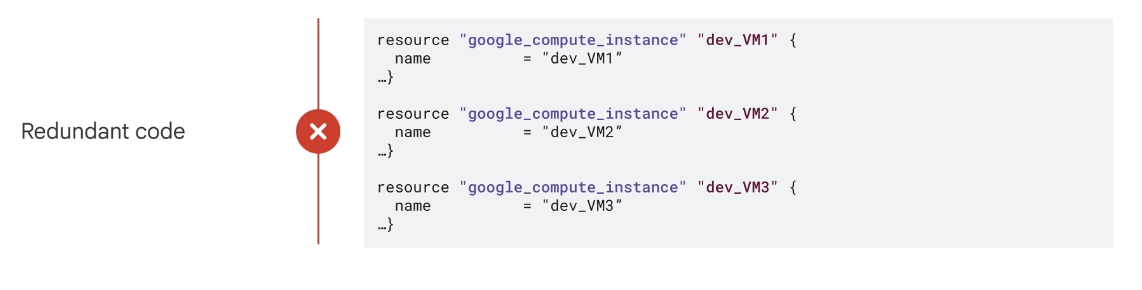

Avoid redundant code and instead create three instances of the same type with names:

```
resource "google_compute_instance" "Dev_VM" {
  count = 3
  name  = "dev_VM${count.index + 1}" # the count.index starts from 0

  # Other required arguments
}
```

### **`for_each`: Multiple resources of the same type with distinct values**

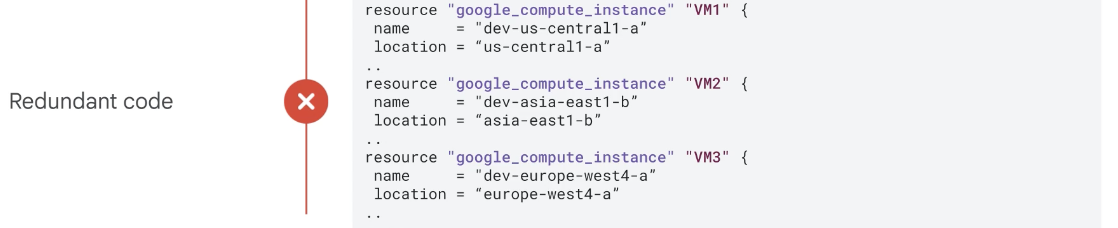

You can instead create three instances with names: `dev-*`"

```
resource "google_compute_instance" "Dev_VM"{
  for_each = toset( ["us-central1-a", "asia-east1-b", "europe-west4-a"] ) # setting a set of strings (or a map)
  name     = "dev-${each.value}"

  zone     = each.value
  # Other required arguments
}

```

## **3.3: Resource Dependencies**


### **Dependency graph**

- While building an infrastructure, you may prefer to have a **visual representation** of how your **infrastructure** is **connected** and **interdependent**

- A **dependency graph** helps you to understand your infrastructure before deploying it

- Terraform builds a dependency graph from your configurations to regenerate plans and refresh states

- The **attributes** are **interpolated** during **runtime** and **primitives** (e.g. variables, output values and providers) are **connected** in a **dependency tree**

- Terraform creates a dependency graph to determine the **correct order of operations**

- In more complex cases, with multiple resources, Terraform will perform **operations in parallel** when it is safe to do so

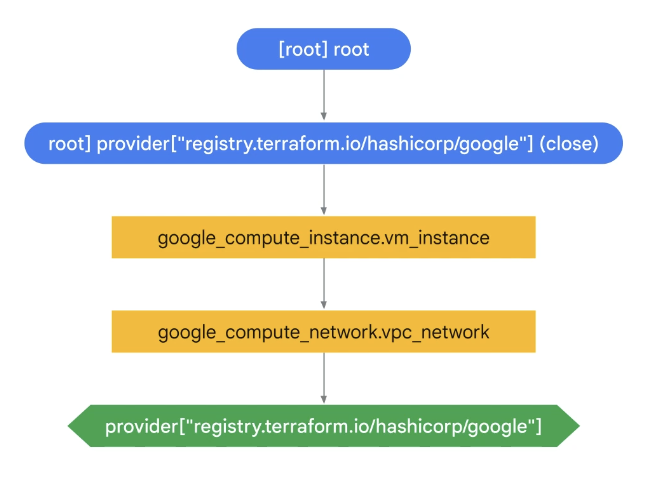

### **Resource Dependencies**

Terraform can handle **two kinds of dependencies**:

- **Implicit dependency**: dependencies known to Terraform are **detected automatically** (e.g., you cannot create a compute instance until the network is created; you cannot assign a static IP address for a compute engine instance until a static IP is reserved)

- **Explicit dependency**: dependencies unknown to Terraform must be **configured explicitely** (for example when you want to ensure a given resource is created only upon the creation of another resource)

### **Implicit resource dependencies are handled automatically**

```
resource "google_compute_instance" "my_instance" {
  // All mandatory arguments

  network_interface {
    // implicit dependency
    network = google_compute_network.my_network.name
    access config{
    }
  }
}

resource "google_compute_network" "my_network" {
  name = "my_network_name"
}
```

- In Google Clooud, you **cannot create a compute instance without a network**. Terraform is informed of these relationships by **interpolation expressions** (which should be used whenever possible)
- The **reference** to `my_network` in the **network argument** of the `google_compute_instance` block creates an **implicit** (**known**) **dependency** on the network specified in the block `google_compute_network.my_network`

- You can **view implicit (known) dependencies** via `terrafom apply` (and also generically the **order** in which **resources** are **created**):

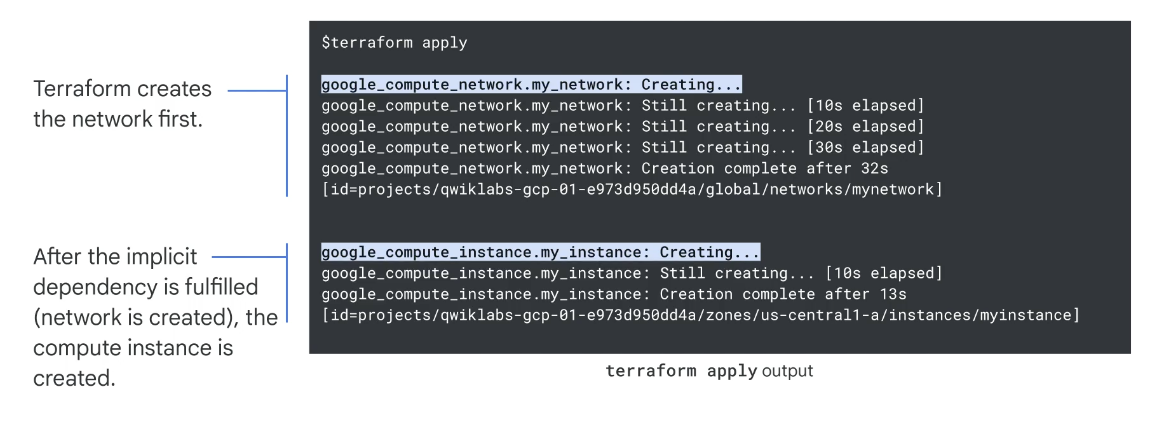

### **Explicit (unknown) dependencies are defined by using the `depends_on` argument**

```
resource "resource_type" "resource_name" {
  ..
  depends_on = [<resource_type>.<resource_name>] # meta-argument for explicit dependency
}
```

For example, the client VM can only be created when the server VM is created:

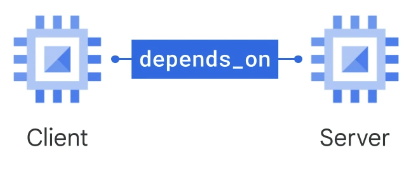

```
resource "google_compute_instance" "client" {
  ..
  depends_on = [google_compute_instance.server] # meta-argument for explicit dependency
}

resource "google_compute_instance" "server" {
  # All required configuration options
}

```

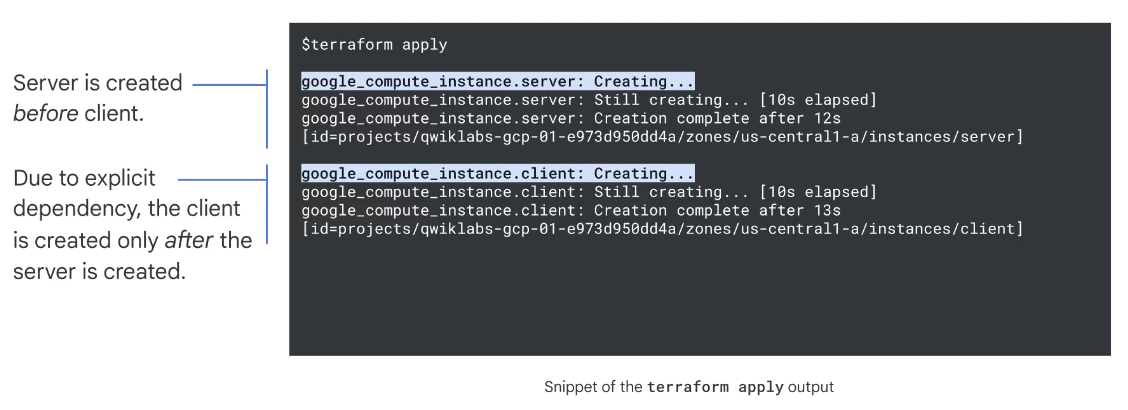

**The order in which resources are defined in your Terraform configuration files has no effect on the order in which Terraform applies your changes**. So you can organise your configuration files in the way that makes the most sense to you